<h2> Searched literature data preprocessing </h2> 

In [311]:
# import packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import random
import re
import time
import numpy as np
import numpy as np
import PyPDF2
import json
import os
import matplotlib.pyplot as plt
import pypdfium2 as pdfium

In [312]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import extract_info
import parameters as params
import download_and_process_pdf as dpp

<h3> Parameters: </h3>

In [313]:
# columns of potential_related_literature_combined.csv
columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]

<h3> Predefined fucntions: </h3> 

In [314]:
def preprocess_pubmed(source_path, output_path, start, end):
    print("Starting preprocessing search results from PubMed...")

    df = pd.read_csv(source_path, sep=',')
    df = df[["DOI", "PMID", "PMCID", "Title"]]
    
    for ind in range(start, end):
        # sleep to avoid to be blocked
        time.sleep(random.randint(1, 3))
        
        # request the webpage
        # the columns PMID, Title don't contain np.nan
        pmid = str(df["PMID"][ind]).strip()
        url = "https://pubmed.ncbi.nlm.nih.gov/" + pmid + "/"
        soup = plib.request_webpage(url)
        # print(soup)
        
        # get pmcid
        if df["PMCID"][ind] != df["PMCID"][ind]: # PMCID is np.nan
            try:
                pmcid = soup.find_all("span", {"class": "identifier pmc"})[0].find_all("a", {"class": "id-link"})[0].get_text().strip()
            except:
                pmcid = np.nan
        else: # PMCID is not np.nan
            pmcid = str(df["PMCID"][ind]).strip()
        # print(pmcid)

        # get doi
        if df["DOI"][ind] != df["DOI"][ind]: # DOI is np.nan
            try:
                doi = soup.find_all("span", {"class": "identifier doi"})[0].find_all("a", {"class": "id-link"})[0].get_text().strip()
            except:
                doi  = np.nan
        else: # DOI is not np.nan
            doi = str(df["DOI"][ind]).strip()
        # print(doi)

        full_text_url = np.nan
        pdf_url = np.nan
        title = (df.at[ind, "Title"]).strip()
        abstract = np.nan
        keywords = np.nan
        
        columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "pdf_url": [pdf_url],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# source_path = fpath.poten_litera_pubmed
# output_path = fpath.poten_litera_pubmed_processed
# plib.clear_file(output_path)

# df = pd.read_csv(source_path, sep=',')
# print(df.shape)
# # (2612, 11)
# df = df[["DOI", "PMID", "PMCID", "Title"]]
# print(df.head(3))
# print(df.shape)

# print(df["DOI"].isnull().values.any())
# print(df["PMID"].isnull().values.any())
# print(df["PMCID"].isnull().values.any())
# print(df["Title"].isnull().values.any())
# # True, False, True, Flase
# # PMID, Title don't contain np.nan
# # DOI, PMCID contain np.nan
# # we need to fill in what are missing
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# preprocess_pubmed(source_path, output_path, start, end)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# ---------------------end of test code---------------------

In [315]:
def preprocess_webofscience(source_path, output_path, start, end):
    print("Starting preprocessing search results from Web of Science...")
    
    df = pd.read_csv(source_path, sep=",")
    df = df[["DOI", "Pubmed Id", "Article Title", "Abstract", "Author Keywords", "Keywords Plus"]]

    for ind in range(start, end):
        # sleep to avoid to be blocked
        time.sleep(random.randint(1, 3))
        
        # the columns Article Title don't contain np.nan
        # the columns DOI and PMID contain np.nan

        # get pmid, doi
        if df["Pubmed Id"][ind] != df["Pubmed Id"][ind]: # Pubmed Id is np.nan
            if df["DOI"][ind] != df["DOI"][ind]: # DOI is np.nan
                doi = np.nan
                pmid = np.nan
            else: # DOI is not np.nan
                doi = str(df["DOI"][ind]).strip()
                pmid = plib.doi2pmid(doi)
        else: # Pubmed Id is not np.nan
            pmid = str(int(df["Pubmed Id"][ind])).strip()
            if df["DOI"][ind] != df["DOI"][ind]: # DOI is not np.nan
                doi, a = plib.pmid2doi_pmcid(pmid)
            else: # DOI is not np.nan
                doi = str(df["DOI"][ind]).strip()
        
        # get pmcid
        if pmid != pmid: # pmid is np.nan
            pmcid = np.nan
        else: # pmid is not np.nan
            # request the webpage
            url = "https://pubmed.ncbi.nlm.nih.gov/" + pmid + "/"
            soup = plib.request_webpage(url)
            # print(soup)

            # get pmcid
            try:
                pmcid = soup.find_all("span", {"class": "identifier pmc"})[0].find_all("a", {"class": "id-link"})[0].get_text().strip()
            except:
                pmcid = np.nan
            # print(pmcid)
            
        full_text_url = np.nan
        pdf_url = np.nan
        title = str(df["Article Title"][ind]).strip()
        abstract = str(df["Abstract"][ind]).strip()
        keywords = str(df["Author Keywords"][ind]).strip() + "; " + str(df["Keywords Plus"][ind]).strip()

        columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "pdf_url": [pdf_url],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# # source_path = fpath.poten_litera_wos
# # output_path = fpath.poten_litera_wos_processed
# plib.clear_file(output_path)

# df = pd.read_csv(source_path, sep=';')
# df = df[["DOI", "Pubmed Id", "Article Title", "Abstract", "Author Keywords", "Keywords Plus"]]
# print(df.head(3))
# print(df.shape)

# print(df["DOI"].isnull().values.any())
# print(df["Pubmed Id"].isnull().values.any())
# print(df["Article Title"].isnull().values.any())
# print(df["Abstract"].isnull().values.any())
# print(df["Author Keywords"].isnull().values.any())
# print(df["Keywords Plus"].isnull().values.any())
# # True, True, False
# # Article Title don't contain np.nan
# # DOI, Pubmed Id contain np.nan
# # we need to fill in what are missing
# ---------------------end of test code--------------------- 

# --------------------start of test code--------------------
# preprocess_webofscience(source_path, output_path, 0, 10)
# ---------------------end of test code--------------------- 

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=';')
# print(df.head(3))
# ---------------------end of test code---------------------  

In [316]:
def preprocess_eupmc(source_path, output_path, start, end):
    print("Starting preprocessing search results from Europe PMC...")

    df = pd.read_csv(source_path, sep=",")
    df = df[["SOURCE", "DOI", "EXTERNAL_ID", "PMCID", "TITLE"]]

    for ind in range(start, end):
        # sleep to avoid to be blocked
        time.sleep(random.randint(1, 3))

        # get pmid, doi
        # SOURCE = {'PMC', 'MED', 'ETH', 'PPR'}
        if df["SOURCE"][ind] != "MED": # SOURCE is not "MED" 
            if df["DOI"][ind] != df["DOI"][ind]: # doi is np.nan
                doi = np.nan
                pmid = np.nan
            else:
                doi = str(df["DOI"][ind]).strip()
                pmid = plib.doi2pmid(doi)
        else: # SOURCE is "MED"
            # get doi, pmid
            if df["EXTERNAL_ID"][ind] != df["EXTERNAL_ID"][ind]: # EXTERNAL_ID is np.nan
                if df["DOI"][ind] != df["DOI"][ind](): # DOI is np.nan
                    doi = np.nan
                    pmid = np.nan
                else: # DOI is not np.nan
                    doi = str(df["DOI"][ind]).strip()
                    pmid = plib.doi2pmid(doi)
            else: # EXTERNAL_ID is not np.nan
                pmid = str(df["EXTERNAL_ID"][ind]).strip()
                if df["DOI"][ind] != df["DOI"][ind]: # DOI is np.nan
                    doi, a = plib.pmid2doi_pmcid(pmid)
                else: # DOI is not np.nan
                    doi = str(df["DOI"][ind]).strip()
                
        # get pmcid
        if pmid != pmid: # pmid is np.nan
            pmcid = df["PMCID"][ind]
        else: # pmid is not np.nan
            # request the webpage
            url = "https://pubmed.ncbi.nlm.nih.gov/" + pmid + "/"
            soup = plib.request_webpage(url)
            # print(soup)

            # get pmcid
            try:
                pmcid = soup.find_all("span", {"class": "identifier pmc"})[0].find_all("a", {"class": "id-link"})[0].get_text().strip()
            except:
                pmcid = np.nan
            # print(pmcid)
        
        full_text_url = np.nan
        pdf_url = np.nan
        title = (df.at[ind, "TITLE"]).strip()
        abstract = np.nan
        keywords = np.nan
        
        columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "pdf_url": [pdf_url],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# source_path = fpath.poten_litera_eupmc
# output_path = fpath.poten_litera_eupmc_processed
# # plib.clear_file(output_path)

# df = pd.read_csv(source_path, sep=',')
# df = df[["SOURCE", "DOI", "EXTERNAL_ID", "PMCID", "TITLE"]]
# print(df.head(3))
# print(df.shape)

# col_one_list = set(df['SOURCE'].tolist())
# print(col_one_list)
# # ['PMC', 'MED', 'ETH', 'PPR']

# print(df["SOURCE"].isnull().values.any())
# print(df["DOI"].isnull().values.any())
# print(df["EXTERNAL_ID"].isnull().values.any())
# print(df["PMCID"].isnull().values.any())
# print(df["TITLE"].isnull().values.any())
# # False, True, False, True, False
# # SOURCE, EXTERNAL_ID, Title don't contain np.nan
# # DOI, PMCID contain np.nan
# # we need to fill in what are missing
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# preprocess_eupmc(source_path, output_path, 0, 10)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# ---------------------end of test code---------------------

In [317]:
def preprocess_google_shcolar_step1(source_path, output_path, start, end):
    print("Starting merging search results from Google Scholar...")

    df = pd.read_csv(source_path, header=None, sep=',')
    df.columns = ["title", "url", "url_tag", "full_text_url", "full_text_tag"]

    for ind in range(start, end):
        # df["url_tag"]: {'[CITATION][C]', '[HTML][HTML]', '[PDF][PDF]', '[BOOK][B]', nan}
        # we don't need books, as they are not likely to include connecivity information
        if df.at[ind, "url_tag"] == "[BOOK][B]":
            continue
        
        # if url or title doesn't exsit AND full_text_url exists
        if (df.at[ind, "url"] != df.at[ind, "url"] or df.at[ind, "title"] != df.at[ind, "title"]) and (df.at[ind, "full_text_tag"] == "[PDF]" or df.at[ind, "full_text_tag"] == "[HTML]"):
            raise Exception(ind, ": url or title are both nan, but full_text_tag is [PDF] or [HTML]!")

        # if url or title doesn't exsit AND full_text_url doesn't exist
        if (df.at[ind, "url"] != df.at[ind, "url"] or df.at[ind, "title"] != df.at[ind, "title"]):
            continue 
        
        title = str(df["title"][ind]).strip()

        # now every row has at least title and url
        if df["url_tag"][ind] == "[PDF][PDF]": # {'[CITATION][C]', '[HTML][HTML]', '[PDF][PDF]', nan}
            if df["full_text_tag"][ind] == "[HTML]": # {'[PDF]', '[HTML]', nan}
                link = str(df["full_text_url"][ind]).strip()
                full_text_url, status_code  = plib.get_final_redirected_url(link)
                if full_text_url == full_text_url:
                    full_text_source = full_text_url.split("://")[1].split("/")[0]
                else:
                    full_text_source = np.nan
            else:
                full_text_url = np.nan
                full_text_source = np.nan
            # get pdf_url, pdf_source
            link = str(df["url"][ind]).strip()
            pdf_url, status_code = plib.get_final_redirected_url(link)
        else: # {'[CITATION][C]', '[HTML][HTML]', nan}
            link = str(df["url"][ind]).strip()
            full_text_url, status_code = plib.get_final_redirected_url(link)
            if full_text_url == full_text_url:
                full_text_source = full_text_url.split("://")[1].split("/")[0]
            else:
                full_text_source = np.nan
            # get pdf_url, pdf_source
            if df["full_text_tag"][ind] == "[PDF]": # full_text_type = {'[HTML]', nan, '[PDF]'}
                link = str(df["full_text_url"][ind]).strip()
                pdf_url, status_code  = plib.get_final_redirected_url(link)
            else:
                pdf_url = np.nan
        
        columns = ["Title", "full_text_url", "full_text_source", "pdf_url"]
        row = {
            "Title": [title],
            "full_text_url": [full_text_url],
            "full_text_source": [full_text_source],
            "pdf_url": [pdf_url]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# source_path = fpath.poten_litera_gs
# output_path = fpath.poten_litera_gs_processed_step1
# plib.clear_file(output_path)

# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["title", "url", "url_tag", "full_text_url", "full_text_tag"]
# # print(df.head(3))
# print(df.shape)
# # (980, 5)

# url_type = set(df['url_tag'].tolist())
# print(url_type)
# # {'[CITATION][C]', '[HTML][HTML]', '[PDF][PDF]', '[BOOK][B]', nan}
# full_text_tag = set(df['full_text_tag'].tolist())
# print(full_text_tag)
# # {'[PDF]', '[HTML]', nan}
# # ---------------------end of test code---------------------

# # --------------------start of test code--------------------
# # ["title", "url", "url_tag", "full_text_url", "full_text_tag"]
# print(df["title"].isnull().any().any())
# print(df["url"].isnull().any().any())
# print(df["url_tag"].isnull().any().any())
# print(df["full_text_url"].isnull().any().any())
# print(df["full_text_tag"].isnull().any().any())
# # True, True, True, True, True
# # title, url, url_tag, full_text_url, full_text_tag, all contain np.nan
# # we need to fill in what are missing
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# preprocess_google_shcolar_step1(source_path, output_path, 0, 1000)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# ---------------------end of test code---------------------

In [318]:
def preprocess_google_shcolar_step2(source_path, output_path, start, end):
    print("Starting merging search results from Google Scholar...")

    df = pd.read_csv(source_path, header=None, sep=',')
    df.columns = ["Title", "full_text_url", "full_text_source", "pdf_url"]

    for ind in range(start, end):
        # get doi from url
        if df["full_text_url"][ind] == df["full_text_url"][ind]: # there's a full_text_url
            url = str(df["full_text_url"][ind]).strip()
            source = url.split("://")[1].split("/")[0]
            # check if the full_text_url is one of our websites
            flag = False
            for website in params.websites_gs:
                if website in source:
                    flag = True
                    break
            if not flag:
                continue
            info = extract_info.extract_info_from_webpage(url, params.websites_gs)
            doi = info["doi"]
            pmid = info["pmid"]
            pmcid = info["pmcid"]
        else:
            url = np.nan
            doi = np.nan
            pmid = np.nan
            pmcid = np.nan
        
        full_text_url = url
        pdf_url = df.at[ind, "pdf_url"]
        title = df.at[ind, "Title"]
        abstract = np.nan
        keywords = np.nan

        columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "pdf_url": [pdf_url],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(doi)
        if doi != doi:
            print([df["full_text_url"][ind]])
        print(ind)
# --------------------start of test code--------------------
# source_path = fpath.poten_litera_gs_processed_step1
# output_path = fpath.poten_litera_gs_processed_step2
# plib.clear_file(output_path)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["Title", "full_text_url", "full_text_source", "pdf_url"]
# # print(df.head(3))
# print(df.shape)
# # (926, 4)
# full_text_source = set(df['full_text_source'].tolist())
# print(full_text_source)
# # {'www.elibrary.ru', 'n.neurology.org', 'jnnp.bmj.com', 'anatomypubs.onlinelibrary.wiley.com', 'academic.oup.com', 
# #  'nyaspubs.onlinelibrary.wiley.com', 'cir.nii.ac.jp', 'link.springer.com', 'www.mdpi.com', 'pure.mpg.de', 
# #  'bmcneurosci.biomedcentral.com', 'elibrary.ru', 'journals.sagepub.com', 'tbiomed.biomedcentral.com', 
# #  'onlinelibrary.wiley.com', 'www.cambridge.org', 'wakespace.lib.wfu.edu', nan, 'www.cell.com', 'europepmc.org', 
# #  'var.scholarpedia.org', 'jpet.aspetjournals.org', 'journal.psych.ac.cn', 'www.biorxiv.org', 'ieeexplore.ieee.org', 
# #  'www.jstor.org', 'www.cabdirect.org', 'royalsocietypublishing.org', 'analyticalsciencejournals.onlinelibrary.wiley.com', 
# #  'open.bu.edu', 'journals.lww.com', 'www.eneuro.org', 'www.jstage.jst.go.jp', 'journals.plos.org', 'www.ncbi.nlm.nih.gov', 
# #  'www.liebertpub.com', 'neuro.psychiatryonline.org', 'www.sciencedirect.com', 'psycnet.apa.org', 'www.taylorfrancis.com', 
# #  'www.degruyter.com', 'www.nature.com', 'jamanetwork.com', 'karger.com', 'www.tandfonline.com', 'journals.physiology.org', 
# #  'movementdisorders.onlinelibrary.wiley.com', 'www.pnas.org', 'www.jneurosci.org', 'thejns.org', 'pascal-francis.inist.fr', 
# #  'physoc.onlinelibrary.wiley.com', 'agro.icm.edu.pl', 'elifesciences.org', 'www.frontiersin.org', 'escholarship.mcgill.ca', 
# #  'ajp.psychiatryonline.org', 'www.science.org', 'books.google.de'}

# # {'elibrary.ru', 'neurology.org', 'bmj.com', 'wiley.com', 'oup.com', 'cir.nii.ac.jp', 'springer.com', 'mdpi.com', 'mpg.de', 
# #  'biomedcentral.com', 'sagepub.com', 'cambridge.org', 'wfu.edu', nan, 'cell.com', 'europepmc.org', 'scholarpedia.org', 
# #  'aspetjournals.org', 'psych.ac.cn', 'biorxiv.org', 'ieee.org', 'jstor.org', 'cabdirect.org', 'royalsocietypublishing.org', 
# #  'bu.edu', 'lww.com', 'eneuro.org', 'jst.go.jp', 'plos.org', 'ncbi.nlm.nih.gov', 'liebertpub.com', 'psychiatryonline.org', 
# #  'sciencedirect.com', 'psycnet.apa.org', 'taylorfrancis.com', 'degruyter.com', 'nature.com', 'jamanetwork.com', 
# #  'karger.com', 'www.tandfonline.com', 'physiology.org', 'www.pnas.org', 'jneurosci.org', 'thejns.org', 
# #  'pascal-francis.inist.fr', 'agro.icm.edu.pl', 'elifesciences.org', 'frontiersin.org', 'mcgill.ca', 
# #  'science.org', 'books.google.de'}

# # websites_gs = {
# #     'neurology.org', 'bmj.com', 'wiley.com', 'oup.com', 'springer.com', 'mdpi.com', 
# #     'biomedcentral.com', 'sagepub.com', 'cambridge.org', 'wfu.edu', 'cell.com', 'europepmc.org', 
# #     'aspetjournals.org', 'psych.ac.cn', 'biorxiv.org', 'ieee.org', 'jstor.org', 'royalsocietypublishing.org', 
# #     'bu.edu', 'lww.com', 'eneuro.org', 'jst.go.jp', 'plos.org', 'ncbi.nlm.nih.gov', 'liebertpub.com', 
# #     'psychiatryonline.org', 'sciencedirect.com', 'psycnet.apa.org', 'degruyter.com', 'nature.com', 'jamanetwork.com', 
# #     'karger.com', 'tandfonline.com', 'physiology.org', 'pnas.org', 'jneurosci.org', 'thejns.org', 
# #     'agro.icm.edu.pl', 'elifesciences.org', 'frontiersin.org', 'science.org'}
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# # ["Title", "full_text_url", "full_text_source", "pdf_url"]
# print(df["Title"].isnull().any().any())
# print(df["full_text_url"].isnull().any().any())
# print(df["full_text_source"].isnull().any().any())
# print(df["pdf_url"].isnull().any().any())
# # False, True, True, True
# # full_text_url, full_text_source, pdf_url contain np.nan
# # we need to fill in what are missing
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# preprocess_google_shcolar_step2(source_path, output_path, 0, 905)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# ---------------------end of test code---------------------

In [319]:
def preprocess_seed_paper_spanning(source_path, output_path):
    print("Starting preprocessing search results from spanning citations of seed paper...")
    return True
# --------------------start of test code--------------------
# test code
# ---------------------end of test code---------------------

In [320]:
def preprocess_cocomac_paper(source_path, output_path):
    print("Starting preprocessing search results from CoCoMac papers...")
    return True
# --------------------start of test code--------------------
# test code
# ---------------------end of test code---------------------

In [321]:
def combine(input, output_path):
    # combine all results
    df = pd.DataFrame()
    for search_result in input:
        df_single = pd.read_csv(search_result, header=None, sep = ",")
        df = pd.concat([df, df_single], ignore_index=True, sort=False)
    
    df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(output_path, header=False, index=False)
# --------------------start of test code--------------------
# gos = fpath.poten_litera_gs_processed_step2
# wos = fpath.poten_litera_wos_processed
# pubmed = fpath.poten_litera_pubmed_processed
# eupmc = fpath.poten_litera_eupmc_processed
# input = [gos, wos, pubmed, eupmc]
# output_path = fpath.poten_litera_combined
# # plib.clear_file(output_path)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# combine(input, output_path)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# print(df.shape)
# # (14627, 8)
# ---------------------end of test code---------------------

In [322]:
def fill_in_identifiers(input_path, output_path, start, end):
    df = pd.read_csv(input_path, header=None, sep = ",")
    df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
    
    # fill in missing identifiers
    for ind in range(start, end):
        # if all 3 identifiers are missing, and full_text_url and pdf_url are missing, skip
        if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"] and df.at[ind, "full_text_url"] != df.at[ind, "full_text_url"] and df.at[ind, "pdf_url"] != df.at[ind, "pdf_url"]:
            continue
        
        # initialzie
        doi = np.nan
        pmid = np.nan
        pmcid = np.nan
        full_text_url = df.at[ind, "full_text_url"]
        pdf_url = df.at[ind, "pdf_url"]
        title = df.at[ind, "Title"]
        abstract = df.at[ind, "Abstract"]
        keywords = df.at[ind, "Keywords"]

        # if all 3 identifiers are missing
        if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"]:
            columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
            row = {
                "DOI": [doi],
                "PMID": [pmid],
                "PMCID": [pmcid],
                "full_text_url": [full_text_url],
                "pdf_url": [pdf_url],
                "Title": [title],
                "Abstract": [abstract],
                "Keywords": [keywords]
            }

            if not plib.add_row_to_csv(output_path, row, columns):
                print("Error detected when adding a row to csv!")

            print(ind)
            continue
        
        # we have at least one of the 3 identifiers
        # doi, pmid
        if df["DOI"][ind] == df["DOI"][ind]: # DOI -> PMID
            doi = str(df["DOI"][ind]).strip().lower()
            # print(doi)
            if df["PMID"][ind] == df["PMID"][ind]:
                pmid = str(df["PMID"][ind]).strip()
                # print(pmid)
            else:
                pmid = plib.doi2pmid(doi)
                # print(pmid)
                if pmid != pmid:
                    pmid_cadidate = plib.title2pmid(title)
                    # print(pmid_cadidate)
        elif df["PMID"][ind] == df["PMID"][ind]: # PMID -> DOI
            pmid = str(int(df["PMID"][ind])).strip()
            # print(pmid)
            doi, pmcid = plib.pmid2doi_pmcid(pmid)
            # print(doi)
        elif df["PMCID"][ind] == df["PMCID"][ind]: # PMCID -> DOI, PMID
            pmcid = str(df["PMCID"][ind]).strip()
            try:
                doi, pmid = plib.pmcid2doi_pmid(pmcid)
            except:
                doi = np.nan
                pmid = np.nan
            # print(doi)
            # print(pmid)
        else:
            doi = np.nan
            pmid = np.nan
        # print(doi)
        # print(pmid)
        
        # pmcid
        if df["PMCID"][ind] == df["PMCID"][ind]:
            pmcid = str(df["PMCID"][ind]).strip()
        elif pmid == pmid:
            a, pmcid = plib.pmid2doi_pmcid(pmid)
        else:
            pmcid = np.nan
        # print(pmcid)
    
        columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "pdf_url": [pdf_url],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")

        print(ind)
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_combined
# # output_path = fpath.poten_litera_filled
# # plib.clear_file(output_path)
# df = pd.read_csv(input_path, header=None, sep = ",")
# print(df.shape)
# df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
# print(df["DOI"].isnull().any().any())
# print(df["PMID"].isnull().any().any())
# print(df["PMCID"].isnull().any().any())
# print(df["full_text_url"].isnull().any().any())
# print(df["pdf_url"].isnull().any().any())
# print(df["Title"].isnull().any().any())
# print(df["Abstract"].isnull().any().any())
# print(df["Keywords"].isnull().any().any())
# True, True, True, True, True, False, True, True
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# fill_in_identifiers(input_path, output_path, 0, 14690)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# df = pd.read_csv(output_path, header=None, sep=',')
# print(df.head(3))
# ---------------------end of test code---------------------

In [323]:
def merge_remove_dupli(input_path, output_path, columns, identifiers): 
    df = pd.read_csv(input_path, header=None, sep = ",")
    df.columns = columns

    # remove all duplicates
    for identifier in identifiers:
        remove_dup_by = identifier
        df = df[df[remove_dup_by].isnull() | ~df[df[remove_dup_by].notnull()].duplicated(subset=remove_dup_by, keep='first')]
        # df = df.drop_duplicates(subset=['DOI'])
        # df = df.drop_duplicates(subset=['PMID'])
        # df = df.drop_duplicates(subset=['PMCID'])

    # reset index
    df.reset_index(drop=True, inplace=True)
    
    df.to_csv(output_path, header=False, index=False)
    print("Duplication in the potential related literature removed.")
# --------------------start of test code--------------------
# source_path = fpath.poten_litera_ids_filled
# output_path = fpath.poten_litra_filtered
# plib.clear_file(output_path)
# ---------------------end of test code---------------------

# --------------------start of test code--------------------
# merge all search results
# identifiers = ["DOI", "PMID", "PMCID"]
# columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
# merge_remove_dupli(source_path, output_path, identifiers)
# ---------------------end of test code---------------------

In [324]:
def full_text_url_filling(input_path, output_path, start, end):
    df = pd.read_csv(input_path, header=None, sep = ",")
    df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
    
    for ind in range(start, end):
        time.sleep(random.randint(1, 3))

        # initialize
        doi = df.at[ind, "DOI"]
        pmid = df.at[ind, "PMID"]
        pmcid = df.at[ind, "PMCID"]
        full_text_url = np.nan
        pdf_url = df.at[ind, "pdf_url"]
        title = df.at[ind, "Title"]
        abstract = df.at[ind, "Abstract"]
        keywords = df.at[ind, "Keywords"]

        # get full text link from pmcid
        if full_text_url!= full_text_url and pmcid == pmcid:
            url = "https://www.ncbi.nlm.nih.gov/pmc/articles/" + str(pmcid).strip() + "/"
            full_text_url, status_code = plib.get_final_redirected_url(url)
            if status_code == 200: # some papers are assined pmcid, but the pmc wepage isn't avaiable until 2024
                full_text_url = full_text_url
            else:
                print(status_code, "Error when trying to get final redirected url from", url)
                full_text_url = np.nan
        
        # get full text url from doi
        if full_text_url != full_text_url and doi == doi:
            url = "https://doi.org/" + str(doi).strip().lower()
            full_text_url, status_code = plib.get_final_redirected_url(url)
            if status_code == 200 or status_code == 403:
                full_text_url = full_text_url
            else:
                print(status_code, "Error when trying to get final redirected url from", url)
                full_text_url = np.nan
                
        # get full text url from pmid
        if full_text_url != full_text_url and pmid == pmid:
            url = "https://pubmed.ncbi.nlm.nih.gov/" + str(int(df.at[ind, "PMID"])).strip() + "/"
            try:
                soup = plib.request_webpage(url)
                link = soup.find("div", {"class": "full-text-links-list"}).find("a", {"class": "link-item pmc"})["href"]
                full_text_url, status_code = plib.get_final_redirected_url(link)
                if status_code == 200:
                    full_text_url = full_text_url
                else:
                    print(status_code, "Error when trying to get final redirected url from", url)
                    full_text_url = np.nan
                    raise Exception()
            except:
                try:
                    soup = plib.request_webpage(url)
                    link = soup.find("div", {"class": "full-text-links-list"}).find("a", {"class": "link-item dialog-focus"})["href"]
                    full_text_url, status_code = plib.get_final_redirected_url(link)
                    if status_code == 200 or status_code == 403:
                        full_text_url = full_text_url
                    else:
                        print(status_code, "Error when trying to get final redirected url from", url)
                        full_text_url = np.nan
                        raise Exception()
                except:
                    full_text_url = np.nan
               
        # get full text url from df.at[ind, "full_text_url"] 
        if full_text_url != full_text_url and df.at[ind, "full_text_url"] == df.at[ind, "full_text_url"]:
            full_text_url, status_code = plib.get_final_redirected_url(df.at[ind, "full_text_url"])
            if status_code == 200 or status_code == 403:
                full_text_url = full_text_url
            else:
                print(status_code, "Error when trying to get final redirected url from", df.at[ind, "full_text_url"])
                full_text_url = np.nan                  
        
        # get full text url from pmid
        if full_text_url != full_text_url and pmid == pmid:
            url = "https://pubmed.ncbi.nlm.nih.gov/" + str(int(df.at[ind, "PMID"])).strip() + "/"
            full_text_url, status_code = plib.get_final_redirected_url(url)
            if status_code == 200:
                full_text_url = full_text_url
            else:
                print(status_code, "Error when trying to get final redirected url from", url)
                full_text_url = np.nan  
        
        # get pdf url, pdf source
        if pdf_url == pdf_url:
            try:
                pdf_url, status_code = plib.get_final_redirected_url(pdf_url)
                if pdf_url == pdf_url:
                    pdf_source = pdf_url.split("://")[1].split("/")[0]
                else:
                    pdf_source = np.nan
            except:
                print("error when getting final redirected url from: ", pdf_url)
                pdf_url = np.nan
                pdf_source = np.nan
        else:
            pdf_source = np.nan

        # get full text source
        if full_text_url == full_text_url:
            full_text_source = full_text_url.split("://")[1].split("/")[0]
        else:
            full_text_source = np.nan
        
        # make sure doi is in lower case
        if doi == doi:
            doi = doi.lower()

        columns = ["DOI", "PMID", "PMCID", "full_text_url", "full_text_source", "pdf_url", "pdf_source", "Title", "Abstract", "Keywords"]
        row = {
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "full_text_url": [full_text_url],
            "full_text_source": [full_text_source],
            "pdf_url": [pdf_url],
            "pdf_source": [pdf_source],
            "Title": [title],
            "Abstract": [abstract],
            "Keywords": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)

In [325]:
def info_filling(input_path, output_path, start, end):
    # scan each row in the potential related literature and extract information
    df = pd.read_csv(input_path, header=None, sep=",")
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in range(start, end):
        # info = {
        #     "doi": np.nan,
        #     "pmid": np.nan,
        #     "pmcid": np.nan,
        #     "title": np.nan,
        #     "abstract": np.nan,
        #     "keywords": np.nan,
        #     "pdf_link": np.nan
        # }

        # initialzie
        index = df.at[ind, "INDEX"]
        doi = df.at[ind, "DOI"]
        pmid = df.at[ind, "PMID"]
        pmcid = df.at[ind, "PMCID"]
        full_text_url = df.at[ind, "FULL_TEXT_URL"]
        full_text_source = df.at[ind, "FULL_TEXT_SOURCE"]
        pdf_url = np.nan
        pdf_source = np.nan
        title = df.at[ind, "TITLE"]
        abstract = df.at[ind, "ABSTRACT"]
        keywords = df.at[ind, "KEYWORDS"]

        if full_text_url != full_text_url: # full text url not found
            if df.at[ind, "PDF_URL"] == df.at[ind, "PDF_URL"]:
                url = str(df.at[ind, "PDF_URL"]).strip()
                url1, status_code = plib.get_final_redirected_url(url)
                if status_code == 200:
                    pdf_url = url
                    pdf_source = pdf_url.split("://")[1].split("/")[0]
                elif status_code == 403:
                    # print(status_code, "when getting final redirected url: ", url)
                    pdf_url = url
                    pdf_source = pdf_url.split("://")[1].split("/")[0]
                else:
                    print(status_code, "when getting final redirected url: ", url)
                    pdf_url = np.nan
                    pdf_source = np.nan  
            else:
                print("full text url and pdf url are not available!")
                pdf_url = np.nan
                pdf_source = np.nan
        elif ('.pdf' in full_text_url and full_text_url.split('.pdf')[1] == '') or ('.PDF' in full_text_url and full_text_url.split('.PDF')[1] == ''):
            print("full text url is a pdf file: ", full_text_url)
            pdf_url = full_text_url
            pdf_source = full_text_source
            full_text_url = np.nan
            full_text_source = np.nan
        else: # full text url found
            flag = False
            for website in params.websites:
                if website in full_text_source:
                    flag = True
                    break
            if not flag:
                continue

            url = str(full_text_url).strip()
            try:
                info = extract_info.extract_info_from_webpage(url, params.websites)
            except:
                raise Exception("Error! Cannot extract information from the webpage: ", url)
            
            # doi
            if info['doi'] == info['doi'] and doi == doi and info['doi'] != doi:
                print(doi)
                print(info['doi'])

            if info['doi'] == info['doi']:
                doi = info['doi'].lower()
            else:
                doi = doi
            
            # pmid
            if info['pmid'] == info['pmid'] and df.at[ind, "PMID"] == df.at[ind, "PMID"] and str(int(info['pmid'])) != str(int(df.at[ind, "PMID"])):
                print(str(int(df.at[ind, "PMID"]))) 
                print(str(int(info['pmid'])))      

            if info['pmid'] == info['pmid']:
                pmid = str(int(info['pmid']))
            elif pmid == pmid:
                pmid = str(int(pmid)).strip()
            else:
                pmid = np.nan
            
            # pmcid
            if info['pmcid'] == info['pmcid'] and pmcid == pmcid and info['pmcid'] != pmcid:
                print(pmcid)
                print(info['pmcid'])

            if info['pmcid'] == info['pmcid']:
                pmcid = info['pmcid']
            else:
                pmcid = df.at[ind, "PMCID"]
            
            # full_text_url, full_text_surce
            if full_text_url == full_text_url:
                full_text_source = full_text_url.split("://")[1].split("/")[0]
            else:
                print("full text url is not available")
                full_text_url = np.nan
                full_text_source = np.nan

            if pdf_url != pdf_url and info['pdf_link'] == info['pdf_link']:
                pdf_url = str(info['pdf_link']).strip()
                pdf_source = pdf_url.split("://")[1].split("/")[0]
                # try:
                #     pdf_url, status_code = plib.get_final_redirected_url(url)
                #     if status_code == 200:
                #         pdf_source = pdf_url.split("://")[1].split("/")[0]
                #     elif status_code == 403:
                #         # print(status_code, "when getting final redirected url: ", url)
                #         pdf_source = pdf_url.split("://")[1].split("/")[0]
                #     else:
                #         print(status_code, "when getting final redirected url: ", url)
                #         pdf_url = np.nan
                #         pdf_source = np.nan
                # except:
                #     pdf_url = np.nan
                #     pdf_source = np.nan 
                    
            if pdf_url != pdf_url and df.at[ind, "PDF_URL"] == df.at[ind, "PDF_URL"]:
                print("PDF_URL not extracted from info: , but existed already: ", df.at[ind, "PDF_URL"])
                pdf_url = df.at[ind, "PDF_URL"]
                pdf_source = pdf_url.split("://")[1].split("/")[0]
            
            if pdf_url != pdf_url:
                if full_text_url == full_text_url and full_text_url.split("://")[1].split("/")[0] == 'www.ncbi.nlm.nih.gov':
                    if doi == doi:
                        url = "https://doi.org/" + doi
                        url, status_code = plib.get_final_redirected_url(url)
                        info = extract_info.extract_info_from_webpage(url, params.websites)
                        full_text_url = url
                        full_text_source = url.split("://")[1].split("/")[0]
                        pdf_url = info["pdf_link"]
                        pdf_source = pdf_url.split("://")[1].split("/")[0]
                    else:
                        pdf_url = np.nan
                        pdf_source = np.nan
                else:  
                    print("PDF_URL not found for: ", doi, pmid, pmcid, full_text_url)
                    pdf_url = np.nan
                    pdf_source = np.nan
                
            # title
            if info['title'] == info['title']:
                title = info['title']
                title = title.replace(";", ",")
            else:
                title = title
            
            # abstract
            if info['abstract'] == info['abstract']:
                abstract = info['abstract']
                abstract = ''.join(e for e in abstract if (e.isalpha() or e == " " or e == "-"))
            else:
                abstract = abstract
            
            # keywords
            if info['keywords'] == info['keywords']:
                keywords = info['keywords']
                keywords = keywords.replace(";", ",")
                keywords = ''.join(e for e in keywords if (e.isalpha() or e == " " or e == "-" or e == ","))
            else:
                keywords = keywords
        
        columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
        
        row = {
            "INDEX": [index],
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "FULL_TEXT_URL": [full_text_url],
            "FULL_TEXT_SOURCE": [full_text_source],
            "PDF_URL": [pdf_url],
            "PDF_SOURCE": [pdf_source],
            "TITLE": [title],
            "ABSTRACT": [abstract],
            "KEYWORDS": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_ids_ftl_filled
# output_path = fpath.poten_litera_litera_db

# # clear file
# plib.clear_file(output_path)

# info_filling(input_path, output_path)
# ---------------------end of test code---------------------

In [326]:
def download_pdf(input_path, pdf_folder, start, end):
    df = pd.read_csv(input_path, header=None, sep=',')
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in range(start, end):
        # time.sleep(3)
        
        # the flag to indicate whether the pdf is downloaded successfully, if not, save the row to poten_litera_pdf_not_available.csv
        flag = False

        pdf_url = df.at[ind, "PDF_URL"]

        # pdf_url not found
        if pdf_url != pdf_url:
            flag = False
        # pdf_url found
        else:
            doi = df.at[ind, "DOI"]
            if dpp.download_and_rename_pdf(pdf_url, doi, df.at[ind, "INDEX"], pdf_folder):
                flag = True
            else:
                print(df.at[ind, "FULL_TEXT_URL"])
                flag = False

        # # pdf_url not found
        # if pdf_url != "://linkinghub.elsevier.com/":
        #     continue
        # # pdf_url found
        # else:
        #     doi = df.at[ind, "DOI"]
        #     if dpp.download_and_rename_pdf(pdf_url, doi, df.at[ind, "INDEX"], pdf_folder):
        #         flag = True
        #     else:
        #         print(df.at[ind, "FULL_TEXT_URL"])
        #         flag = False
        
        if not flag:
            print("PDF_URL not found or PDF not successfully downloaded for: ")
            print("\n")
            print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"], df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"], df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"], df.at[ind, "TITLE"], df.at[ind, "ABSTRACT"], df.at[ind, "KEYWORDS"])
            # print("\n")

        line_number_in_csv = ind + 1
        print(ind, " Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
        print("\n")

In [327]:
def pdf2text(pdf_path, text_path): 
    try:   
        # # creating a pdf reader object
        # reader = PyPDF2.PdfReader(pdf_path)
        
        # # printing number of pages in pdf file
        # page_max = len(reader.pages)
        # # print(page_max)
        
        # # getting a specific page from the pdf file
        # text = ""
        
        # for i in range(0, page_max):
        #     page = reader.pages[i]
        #     text = text + " ".join(page.extract_text().splitlines())

        # with open(text_path, "w") as f:
        #     f.write(text)
        # f.close()

        text = ""
        pdf = pdfium.PdfDocument(pdf_path)
        n_pages = len(pdf)
        for i in range(n_pages):
            page = pdf[i]
            textpage = page.get_textpage()
            text += textpage.get_text_range() + " "
            # text += textpage.get_text()
            # text += "\n"
            [g.close() for g in (textpage, page)]
        pdf.close()

        # remove non-ASCII characters from the string
        text = text.encode('ascii', 'ignore').decode()
        text = text.replace("\n", " ").replace("\r\n", " ").replace("\r", " ").replace("\t", " ")
        # remove extra spaces
        text = re.sub(' +', ' ', text)

        with open(text_path, "w") as f:
            f.write(text)
        f.close()
    except:
        print("ERROR! ERROR!")
        print("ERROR when converting pdf to text for: ", pdf_path)
# --------------------start of test code--------------------
# index = 0
# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder

# pdf_file_name = str(index) + ".pdf"
# pdf_path = os.path.join(pdf_folder, pdf_file_name)
# text_path = os.path.join(text_folder, pdf_file_name.split(".pdf")[0] + ".txt")
# # print(pdf_path)
# # print(text_path)
# pdf2text(pdf_path, text_path)
# ---------------------end of test code---------------------

In [328]:
def json2text(json_path, text_path):    
    with open(json_path, "r") as f:
        json_file = json.load(f)
        text = json_file["full-text-retrieval-response"]["originalText"]
    f.close()

    title = json_file["full-text-retrieval-response"]["coredata"]["dc:title"]

    text = title + " " + text.split(title)[1]
    text = re.sub(' +', ' ', text)

    with open(text_path, "w") as f:
        f.write(text)
    f.close()
# --------------------start of test code--------------------
# index = 1
# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder
# start_page = 0
# text_length_to_extract = 1000

# json_file_name = str(index) + ".json"
# json_path = os.path.join(pdf_folder, json_file_name)
# text_path = os.path.join(text_folder, str(index) + ".txt")
# # print(pdf_path)
# # print(text_path)
# json2text(json_path, text_path, text_length_to_extract)
# ---------------------end of test code---------------------

<h3> Main program: </h3> 

<h4> 1. Preprocess and combine search results </h4>

In [329]:
# # preprocess search results from PubMed

# source_path = fpath.poten_litera_pubmed
# output_path = fpath.poten_litera_pubmed_processed

# # clear the file
# # plib.clear_file(output_path)

# # preprocess search results from PubMed
# # 2612 results
# preprocess_pubmed(source_path, output_path, 0, 2612)
# print("preprocessing results from PubMed succeeded!")
# # print("Attention! Something went wrong when preprocessing results from PubMed!")

In [330]:
# combine search results from Web of Science
# # clear the file
# plib.clear_file(fpath.poten_litera_wos)

# # combine the 2 files of search results from web of science
# source_path_1 = fpath.poten_litera_wos_1
# source_path_2 = fpath.poten_litera_wos_2
# df_1 = pd.read_csv(source_path_1, sep=',')
# df_2 = pd.read_csv(source_path_2, sep=',')
# df_1.to_csv(fpath.poten_litera_wos, header=True, index=False, sep=",")
# df_2.to_csv(fpath.poten_litera_wos, mode="a", header=False, index=False, sep=",")
# # --------------------start of test code--------------------
# df = pd.read_csv(fpath.poten_litera_wos, sep=',')
# print(df.head(3))
# print(df.shape)
# # (1993, 72)
# # ---------------------end of test code---------------------

In [331]:
# # preprocess search results from Web of Science

# source_path = fpath.poten_litera_wos
# output_path = fpath.poten_litera_wos_processed

# # clear the file
# # plib.clear_file(output_path)

# # preprocess search results from Web of Science
# # 1993 results
# preprocess_webofscience(source_path, output_path, 0, 1993)
# print("preprocessing results from Web of Science succeeded!")
# # print("Attention! Something went wrong when preprocessing results from Web of Science!")

In [332]:
# # preprocess search results from Europe PMC

# source_path = fpath.poten_litera_eupmc
# output_path = fpath.poten_litera_eupmc_processed

# # clear the file
# # plib.clear_file(output_path)

# # preprocess search results from Europe PMC
# preprocess_eupmc(source_path, output_path, 2980, 9178)
# # 9178 results
# print("preprocessing results from Europe PMC succeeded!")
# # print("Attention! Something went wrong when preprocessing results from Europe PMC!")

# # 2980

In [333]:
# # preprocess search results from Google Scholar step 1

# source_path = fpath.poten_litera_gs
# # 980 results
# output_path = fpath.poten_litera_gs_processed_step1

# # clear the file
# # plib.clear_file(output_path)

# # preprocess search results from Google Scholar
# preprocess_google_shcolar_step1(source_path, output_path, 0, 980)
# # 926 results
# print("step 1 of preprocessing results from Google Scholar succeeded!")
# # print("Attention! Something went wrong when preprocessing results from Google Scholar step 1!")

In [334]:
# # reset index for poten_litera_gs_processed_step1
# input_path = fpath.poten_litera_gs_processed_step1
# output_path = fpath.poten_litera_gs_processed_step1
# df = pd.read_csv(input_path, header=None, sep = ",")
# df.reset_index(drop=True, inplace=True)
# df.to_csv(output_path, header=False, index=False)

# input_path = fpath.poten_litera_gs_processed_step1
# df = pd.read_csv(input_path, header=None, sep = ",")
# print(df.shape)
# # (926, 4)

In [335]:
# # preprocess search results from Google Scholar step 2

# source_path = fpath.poten_litera_gs_processed_step1
# # (926, 4)
# output_path = fpath.poten_litera_gs_processed_step2


# # clear the file
# # plib.clear_file(output_path)

# # preprocess search results from Google Scholar
# preprocess_google_shcolar_step2(source_path, output_path, 0, 926)
# print("step 2 of preprocessing results from Google Scholar succeeded!")
# # print("Attention! Something went wrong when preprocessing results from Google Scholar step 2!")

In [336]:
# # reset index for poten_litera_gs_processed_step2
# input_path = fpath.poten_litera_gs_processed_step2
# output_path = fpath.poten_litera_gs_processed_step2
# df = pd.read_csv(input_path, header=None, sep = ",")
# df.reset_index(drop=True, inplace=True)
# df.to_csv(output_path, header=False, index=False)

# input_path = fpath.poten_litera_gs_processed_step2
# df = pd.read_csv(input_path, header=None, sep = ",")
# print(df.shape)
# # (926, 4)

In [337]:
# # preprocess search results from spanning citations of seed paper

# preprocess_seed_paper_spanning(source_path, output_path, columns):
# print("preprocessing results from spanning citations of seed papers succeeded!")
# # print("Attention! Something went wrong when preprocessing results from spanning citations of seed papers!")

In [338]:
# # preprocess search results from CoCoMac papers

# preprocess_cocomac_paper(source_path, output_path, columns)
# print("preprocessing results from CoCoMac papers succeeded!")
# # print("Attention! Something went wrong when preprocessing results from CoCoMac papers!")

In [339]:
# # take a look at all the preprossed search results
# gos = fpath.poten_litera_gs_processed_step2
# wos = fpath.poten_litera_wos_processed
# pubmed = fpath.poten_litera_pubmed_processed
# eupmc = fpath.poten_litera_eupmc_processed

# df_gs = pd.read_csv(gos, header=None, sep=',')
# print(df_gs.shape)
# # (907, 6)
# df_wos = pd.read_csv(wos, header=None, sep=',')
# print(df_wos.shape)
# # (1993, 8)
# df_pubmed = pd.read_csv(pubmed, header=None, sep=',')
# print(df_pubmed.shape)
# # (2612, 8)
# df_eupmc = pd.read_csv(eupmc, header=None, sep=',')
# print(df_eupmc.shape)
# # (9178, 8)

In [340]:
# # combine all search results

# gos = fpath.poten_litera_gs_processed_step2
# wos = fpath.poten_litera_wos_processed
# pubmed = fpath.poten_litera_pubmed_processed
# eupmc = fpath.poten_litera_eupmc_processed
# input = [gos, wos, pubmed, eupmc]
# output_path = fpath.poten_litera_combined

# # clear the file
# plib.clear_file(output_path)

# combine(input, output_path)
# # (14627, 8)
# print("Combining all search results succeeded!")
# # print("Attention! Something went wrong when combining all search results!")

# df_combined = pd.read_csv(output_path, header=None, sep=',')
# print(df_combined.shape)
# # (14690, 8)

In [341]:
# # fill in missing identifiers
# input_path = fpath.poten_litera_combined
# output_path = fpath.poten_litera_ids_filled

# # clear file
# # plib.clear_file(output_path)

# fill_in_identifiers(input_path, output_path, 0, 14690)
# print("Filling in missing elements succeeded!")

In [342]:
# # check the missing elements in the combined search results
# source_path = fpath.poten_litera_ids_filled
# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
# # for ind in df.index:
# #     if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"] and df.at[ind, "full_text_url"] != df.at[ind, "full_text_url"] and df.at[ind, "pdf_url"] != df.at[ind, "pdf_url"]:
# #         print(ind)
# #         print(df.at[ind, "Title"])
# #         print(df.at[ind, "full_text_url"])
# #         print(df.at[ind, "pdf_url"])

# # for ind in df.index:
# #     if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"] and df.at[ind, "full_text_url"] != df.at[ind, "full_text_url"]:
# #         print(ind)
# #         print(df.at[ind, "Title"])
# #         print(df.at[ind, "full_text_url"])
# #         print(df.at[ind, "pdf_url"])

In [343]:
# # merge all search results and remove duplication by identifiers

# source_path = fpath.poten_litera_ids_filled
# output_path = fpath.poten_litra_filtered

# # clear the file
# plib.clear_file(output_path)

# # merge all search results
# identifiers = ["DOI", "PMID", "PMCID"]
# columns = ["DOI", "PMID", "PMCID", "full_text_url", "pdf_url", "Title", "Abstract", "Keywords"]
# merge_remove_dupli(source_path, output_path, columns, identifiers)

# --------------------start of test code--------------------
# source_path = fpath.poten_litra_filtered
# df = pd.read_csv(source_path, header=None, sep=',')
# print(df.shape)
# # (10982, 8)
# ---------------------end of test code---------------------

<h4> 2. Filling in missing information and construct database </h4>

In [344]:
# # fill in full_text_url

# source_path = fpath.poten_litra_filtered
# output_path = fpath.poten_litera_ids_ftl_filled

# # clear the file
# # plib.clear_file(output_path)

# # merge all search results
# full_text_url_filling(source_path, output_path, 0, 10980)

In [345]:
# # remove duplications and reset the index and add index column
# source_path = fpath.poten_litera_ids_ftl_filled
# output_path = fpath.poten_litera_ids_ftl_filled_filtered

# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["DOI", "PMID", "PMCID", "full_text_url", "full_text_source", "pdf_url", "pdf_source", "Title", "Abstract", "Keywords"]
# identifiers = ["DOI", "PMID", "PMCID"]
# # merge_remove_dupli(source_path, output_path, columns, identifiers)

# for identifier in identifiers:
#     remove_dup_by = identifier
#     df = df[df[remove_dup_by].isnull() | ~df[df[remove_dup_by].notnull()].duplicated(subset=remove_dup_by, keep='last')]

# # reset index
# df.reset_index(drop=True, inplace=True)

# df.to_csv(output_path, header=False, index=True)
# print("Duplication in the potential related literature removed.")
# # --------------------start of test code--------------------
# output_path = fpath.poten_litera_ids_ftl_filled_filtered
# df_output = pd.read_csv(output_path, header=None, sep=',')
# print(df_output.head(5))
# print(df_output.shape)
# # (10980, 11)
# # ---------------------end of test code---------------------

In [346]:
# # check the missing elements
# source_path = fpath.poten_litera_ids_ftl_filled_filtered
# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "full_text_url", "full_text_source", "pdf_url", "pdf_source", "Title", "Abstract", "Keywords"]

# # # if all 3 identifiers are missing, and full_text_url and pdf_url are missing
# # for ind in df.index:
# #     if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"] and df.at[ind, "full_text_url"] != df.at[ind, "full_text_url"] and df.at[ind, "pdf_url"] != df.at[ind, "pdf_url"]:
# #         print(ind)
# #         print(df.at[ind, "Title"])
# #         print(df.at[ind, "full_text_url"])
# #         print(df.at[ind, "pdf_url"])
# # # None

# # if all 3 identifiers are missing and full_text_url is missing, but pdf_url is available
# for ind in df.index:
#     if df.at[ind, "DOI"] != df.at[ind, "DOI"] and df.at[ind, "PMID"] != df.at[ind, "PMID"] and df.at[ind, "PMCID"] != df.at[ind, "PMCID"] and df.at[ind, "full_text_url"] != df.at[ind, "full_text_url"]:
#         print(ind)
#         print(df.at[ind, "Title"])
#         print(df.at[ind, "full_text_url"])
#         print(df.at[ind, "pdf_url"])

In [347]:
# # check all possible full_text_source
# input_path = fpath.poten_litera_ids_ftl_filled_filtered
# df = pd.read_csv(input_path, header=None, sep=",")
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# print(df.shape)
# # (10980, 11)

# # ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# print(df["FULL_TEXT_URL"].isnull().any().any()) # True
# print(df["FULL_TEXT_SOURCE"].isnull().any().any()) # True
# print(df["TITLE"].isnull().any().any()) # False

# print(df["INDEX"].dtypes) # int64
# print(df["DOI"].dtypes) # object
# print(df["PMID"].dtypes) # float64
# print(df["PMCID"].dtypes) # object
# print(df["FULL_TEXT_URL"].dtypes) # object
# print(df["FULL_TEXT_SOURCE"].dtypes) # object
# print(df["PDF_URL"].dtypes) # object
# print(df["PDF_SOURCE"].dtypes) # object
# print(df["TITLE"].dtypes) # object
# print(df["ABSTRACT"].dtypes) # object
# print(df["KEYWORDS"].dtypes) # object

# full_text_source_dict = set(df['FULL_TEXT_SOURCE'].tolist())
# print(full_text_source_dict)
# full_text_source_dict = {'pharmrev.aspetjournals.org', 'www.ingentaconnect.com', 'pubs.aip.org', 'journal.psych.ac.cn', 'iovs.arvojournals.org', 
# 'linkinghub.elsevier.com', 'www.architalbiol.org', 'open.bu.edu', 'psycnet.apa.org:443', 'jamanetwork.com', 
# 'link.springer.com', 'europepmc.org', 'www.ncbi.nlm.nih.gov', 'thejns.org', 'ujms.net', 'jpet.aspetjournals.org', 
# 'journals.biologists.com', 'www.thieme-connect.de', 'academic.oup.com', 'direct.mit.edu', 'ajp.psychiatryonline.org', 
# 'journals.lww.com', 'wakespace.lib.wfu.edu', 'www.ahajournals.org', 'symposium.cshlp.org', 'www.microbiologyresearch.org', 
# 'journals.aps.org', 'www.cambridge.org', 'www.imrpress.com', 'www.jstor.org', 'www.researchsquare.com', 'www.science.org', 
# 'content.iospress.com:443', 'n.neurology.org', 'royalsocietypublishing.org', 'ieeexplore.ieee.org', 'neuro.psychiatryonline.org', 
# 'pubmed.ncbi.nlm.nih.gov', 'analyticalsciencejournals.onlinelibrary.wiley.com', 'www.rbojournal.org', 'papers.ssrn.com', 
# 'www.worldscientific.com', 'www.jstage.jst.go.jp', 'webview.isho.jp', 'www.degruyter.com', 'www.taylorfrancis.com', 
# 'www.biorxiv.org', 'nan', 'www.liebertpub.com', 'opg.optica.org', 'jnm.snmjournals.org', 'neurologia.com', 'www.nature.com', 
# 'karger.com', 'www.tandfonline.com', 'onlinelibrary.wiley.com', 'www.ajtmh.org', 'pubs.acs.org', 'www.annualreviews.org', 
# 'journals.physiology.org', 'journals.sagepub.com', 'pubs.asahq.org', 'nrc-prod.literatumonline.com'}

# # dict2 = {}

# # print(full_text_source_dict == dict2) # True

In [348]:
# # websites_hosts
# # {'pharmrev.aspetjournals.org', 'www.ingentaconnect.com', 'pubs.aip.org', 'journal.psych.ac.cn', 'iovs.arvojournals.org', 
# # 'linkinghub.elsevier.com', 'www.architalbiol.org', 'open.bu.edu', 'psycnet.apa.org:443', 'jamanetwork.com', 
# # 'link.springer.com', 'europepmc.org', 'www.ncbi.nlm.nih.gov', 'thejns.org', 'ujms.net', 'jpet.aspetjournals.org', 
# # 'journals.biologists.com', 'www.thieme-connect.de', 'academic.oup.com', 'direct.mit.edu', 'ajp.psychiatryonline.org', 
# # 'journals.lww.com', 'wakespace.lib.wfu.edu', 'www.ahajournals.org', 'symposium.cshlp.org', 'www.microbiologyresearch.org', 
# # 'journals.aps.org', 'www.cambridge.org', 'www.imrpress.com', 'www.jstor.org', 'www.researchsquare.com', 'www.science.org', 
# # 'content.iospress.com:443', 'n.neurology.org', 'royalsocietypublishing.org', 'ieeexplore.ieee.org', 'neuro.psychiatryonline.org', 
# # 'pubmed.ncbi.nlm.nih.gov', 'analyticalsciencejournals.onlinelibrary.wiley.com', 'www.rbojournal.org', 'papers.ssrn.com', 
# # 'www.worldscientific.com', 'www.jstage.jst.go.jp', 'webview.isho.jp', 'www.degruyter.com', 'www.taylorfrancis.com', 
# # 'www.biorxiv.org', 'nan', 'www.liebertpub.com', 'opg.optica.org', 'jnm.snmjournals.org', 'neurologia.com', 'www.nature.com', 
# # 'karger.com', 'www.tandfonline.com', 'onlinelibrary.wiley.com', 'www.ajtmh.org', 'pubs.acs.org', 'www.annualreviews.org', 
# # 'journals.physiology.org', 'journals.sagepub.com', 'pubs.asahq.org', 'nrc-prod.literatumonline.com'}

# websites_hosts = [
#     'aspetjournals.org', 'www.ingentaconnect.com', 'pubs.aip.org', 'journal.psych.ac.cn', 'iovs.arvojournals.org', 
#     'linkinghub.elsevier.com', 'www.architalbiol.org', 'open.bu.edu', 'psycnet.apa.org', 'jamanetwork.com', 
#     'link.springer.com', 'europepmc.org', 'www.ncbi.nlm.nih.gov', 'thejns.org', 'ujms.net',
#     'journals.biologists.com', 'www.thieme-connect.de', 'academic.oup.com', 'direct.mit.edu', 'psychiatryonline.org', 
#     'journals.lww.com', 'wakespace.lib.wfu.edu', 'www.ahajournals.org', 'symposium.cshlp.org', 'www.microbiologyresearch.org', 
#     'journals.aps.org', 'www.cambridge.org', 'www.imrpress.com', 'www.jstor.org', 'www.researchsquare.com', 'www.science.org', 
#     'content.iospress.com', 'neurology.org', 'royalsocietypublishing.org', 'ieeexplore.ieee.org', 
#     'pubmed.ncbi.nlm.nih.gov', 'wiley.com', 
#     'www.rbojournal.org', 'papers.ssrn.com', 'www.worldscientific.com', 'www.jstage.jst.go.jp', 'webview.isho.jp', 
#     'www.degruyter.com', 'www.taylorfrancis.com', 'www.biorxiv.org', 'nan', 'www.liebertpub.com', 'opg.optica.org', 
#     'jnm.snmjournals.org', 'neurologia.com', 'www.nature.com', 'karger.com', 'www.tandfonline.com',
#     'www.ajtmh.org', 'pubs.acs.org', 'www.annualreviews.org', 'journals.physiology.org', 'journals.sagepub.com', 
#     'pubs.asahq.org', 'literatumonline.com'
# ]

# # --------------------start of test code--------------------
# if len(websites_hosts) == len(set(websites_hosts)):
#     print("There are no duplicates in the list.")
# else:
#     print("There are duplicates in the list.")
# # ---------------------end of test code---------------------

In [349]:
# # sort the websites by the number of articles they have
# input_path = fpath.poten_litera_ids_ftl_filled_filtered
# df = pd.read_csv(input_path, header=None, sep=",")
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# func_dict = {website: 0 for website in websites_hosts}
# # print(func_dict)

# for ind in df.index:
#     if df.at[ind, "FULL_TEXT_SOURCE"] != df.at[ind, "FULL_TEXT_SOURCE"]:
#         func_dict["nan"] += 1
#         continue
#     for website in websites_hosts:
#         if website in df.at[ind, "FULL_TEXT_SOURCE"]:
#             func_dict[website] += 1
#             break

# # Sort dictionary by values
# sorted_dict = dict(sorted(func_dict.items(), key=lambda item: item[1], reverse=True))
# print(sorted_dict)
# # {'www.ncbi.nlm.nih.gov': 7913, 'linkinghub.elsevier.com': 1023, 'wiley.com': 701, 'link.springer.com': 288, 
# # 'journals.physiology.org': 200, 'academic.oup.com': 152, 'pubmed.ncbi.nlm.nih.gov': 147, 'www.cambridge.org': 74, 
# # 'karger.com': 54, 'journals.lww.com': 49, 'www.nature.com': 45, 'nan': 38, 'www.science.org': 30, 
# # 'www.tandfonline.com': 29, 'journals.sagepub.com': 21, 'jamanetwork.com': 20, 'neurology.org': 16, 
# # 'www.biorxiv.org': 15, 'europepmc.org': 14, 'iovs.arvojournals.org': 13, 'royalsocietypublishing.org': 13, 
# # 'psycnet.apa.org': 12, 'psychiatryonline.org': 12, 'direct.mit.edu': 11, 'www.jstage.jst.go.jp': 11, 
# # 'thejns.org': 8, 'www.annualreviews.org': 8, 'aspetjournals.org': 7, 'jnm.snmjournals.org': 7, 
# # 'www.architalbiol.org': 4, 'www.ahajournals.org': 4, 'content.iospress.com': 3, 'www.worldscientific.com': 3, 
# # 'www.liebertpub.com': 3, 'pubs.acs.org': 3, 'www.thieme-connect.de': 2, 'opg.optica.org': 2, 
# # 'neurologia.com': 2, 'pubs.asahq.org': 2, 'www.ingentaconnect.com': 1, 'pubs.aip.org': 1, 'journal.psych.ac.cn': 1, 
# # 'open.bu.edu': 1, 'ujms.net': 1, 'journals.biologists.com': 1, 'wakespace.lib.wfu.edu': 1, 
# # 'symposium.cshlp.org': 1, 'www.microbiologyresearch.org': 1, 'journals.aps.org': 1, 'www.imrpress.com': 1, 
# # 'www.jstor.org': 1, 'www.researchsquare.com': 1, 'ieeexplore.ieee.org': 1, 'www.rbojournal.org': 1, 
# # 'papers.ssrn.com': 1, 'webview.isho.jp': 1, 'www.degruyter.com': 1, 'www.taylorfrancis.com': 1, 
# # 'www.ajtmh.org': 1, 'literatumonline.com': 1}

# non_zero_keys = [key for key, value in sorted_dict.items() if value != 0]
# print(non_zero_keys)
# # ['www.ncbi.nlm.nih.gov', 'linkinghub.elsevier.com', 'wiley.com', 'link.springer.com', 'journals.physiology.org', 
# # 'academic.oup.com', 'pubmed.ncbi.nlm.nih.gov', 'www.cambridge.org', 'karger.com', 'journals.lww.com', 
# # 'www.nature.com', 'nan', 'www.science.org', 'www.tandfonline.com', 'journals.sagepub.com', 'jamanetwork.com', 
# # 'neurology.org', 'www.biorxiv.org', 'europepmc.org', 'iovs.arvojournals.org', 'royalsocietypublishing.org', 
# # 'psycnet.apa.org', 'psychiatryonline.org', 'direct.mit.edu', 'www.jstage.jst.go.jp', 'thejns.org', 
# # 'www.annualreviews.org', 'aspetjournals.org', 'jnm.snmjournals.org', 'www.architalbiol.org', 'www.ahajournals.org', 
# # 'content.iospress.com', 'www.worldscientific.com', 'www.liebertpub.com', 'pubs.acs.org', 'www.thieme-connect.de', 
# # 'opg.optica.org', 'neurologia.com', 'pubs.asahq.org', 'www.ingentaconnect.com', 'pubs.aip.org', 'journal.psych.ac.cn', 
# # 'open.bu.edu', 'ujms.net', 'journals.biologists.com', 'wakespace.lib.wfu.edu', 'symposium.cshlp.org', 
# # 'www.microbiologyresearch.org', 'journals.aps.org', 'www.imrpress.com', 'www.jstor.org', 'www.researchsquare.com', 
# # 'ieeexplore.ieee.org', 'www.rbojournal.org', 'papers.ssrn.com', 'webview.isho.jp', 'www.degruyter.com', 
# # 'www.taylorfrancis.com', 'www.ajtmh.org', 'literatumonline.com']

In [350]:
# # websites
# websites = [
#     'www.ncbi.nlm.nih.gov', 'linkinghub.elsevier.com', 'wiley.com', 'link.springer.com', 'journals.physiology.org', 
#     'academic.oup.com', 'pubmed.ncbi.nlm.nih.gov', 'www.cambridge.org', 'karger.com', 'journals.lww.com', 
#     'www.nature.com', 'nan', 'www.science.org', 'www.tandfonline.com', 'journals.sagepub.com', 'jamanetwork.com', 
#     'neurology.org', 'www.biorxiv.org', 'europepmc.org', 'iovs.arvojournals.org', 'royalsocietypublishing.org', 
#     'psycnet.apa.org', 'psychiatryonline.org', 'direct.mit.edu', 'www.jstage.jst.go.jp', 'thejns.org', 
#     'www.annualreviews.org', 'aspetjournals.org', 'jnm.snmjournals.org', 'www.architalbiol.org', 'www.ahajournals.org', 
#     'content.iospress.com', 'www.worldscientific.com', 'www.liebertpub.com', 'pubs.acs.org', 'www.thieme-connect.de', 
#     'opg.optica.org', 'neurologia.com', 'pubs.asahq.org', 'www.ingentaconnect.com', 'pubs.aip.org', 'journal.psych.ac.cn', 
#     'open.bu.edu', 'ujms.net', 'journals.biologists.com', 'wakespace.lib.wfu.edu', 'symposium.cshlp.org', 
#     'www.microbiologyresearch.org', 'journals.aps.org', 'www.imrpress.com', 'www.jstor.org', 'www.researchsquare.com', 
#     'ieeexplore.ieee.org', 'www.rbojournal.org', 'papers.ssrn.com', 'webview.isho.jp', 'www.degruyter.com', 
#     'www.taylorfrancis.com', 'www.ajtmh.org', 'literatumonline.com'
# ]
# # --------------------start of test code--------------------
# # if len(websites) == len(websites_hosts):
# #     print('The number of websites is correct')
# # ---------------------end of test code---------------------

In [351]:
# # websites to remove

# # Reasons to move literature from these websites:
# # 1. nan
# # 2. full text not available
# # 3. non-English
# # 4. theses or dissertations

# # 'pubmed.ncbi.nlm.nih.gov', 
# # https://pubmed.ncbi.nlm.nih.gov/4984008/
# # full text not available
# # 'nan', 
# # full text not available
# # 'psycnet.apa.org', 
# # https://psycnet.apa.org/doiLanding?doi=10.1037%2F0735-7044.112.3.719
# # full text not available
# # 'content.iospress.com', 
# # https://content.iospress.com:443/articles/restorative-neurology-and-neuroscience/rnn140440
# # full text not available
# # 'www.worldscientific.com', 
# # https://www.worldscientific.com/doi/abs/10.1142/S0192415X06004296
# # full text not available
# # 'www.liebertpub.com', 
# # https://www.liebertpub.com/doi/10.1089/hum.2006.17.291
# # full text not available
# # 'opg.optica.org', 
# # https://opg.optica.org/josaa/viewmedia.cfm?uri=josaa-3-10-1726&seq=0
# # full text not available
# # 'neurologia.com', 
# # https://neurologia.com/articulo/99529
# # non-English
# # 'pubs.aip.org', 
# # https://pubs.aip.org/asa/jasa/article-abstract/104/5/2935/560140/Click-train-encoding-in-primary-auditory-cortex-of?redirectedFrom=fulltext
# # full text not available
# # 'journal.psych.ac.cn', 
# # https://journal.psych.ac.cn/adps/EN/abstract/abstract3663.shtml
# # full text not available
# # 'open.bu.edu', 
# # https://open.bu.edu/handle/2144/12127
# # theses or dissertations
# # 'wakespace.lib.wfu.edu', 
# # https://wakespace.lib.wfu.edu/handle/10339/37434
# # theses or dissertations, full text not available
# # 'symposium.cshlp.org', 
# # https://symposium.cshlp.org/content/61/39.long
# # full text not available
# # 'www.jstor.org', 
# # https://www.jstor.org/stable/82698
# # full text not available
# # 'www.rbojournal.org', 
# # https://www.rbojournal.org/article/influencia-da-thalamosinusotomia-sob-diferentes-pressoes-intra-oculares-constantes-na-facilidade-de-drenagem-do-humor-aquoso-em-olhos-de-porco/
# # non-English
# # 'webview.isho.jp', 
# # https://webview.isho.jp/openurl?rft.genre=article&rft.issn=1881-6096&rft.volume=63&rft.issue=5&rft.spage=473
# # non-English
# # 'www.degruyter.com', 
# # https://www.degruyter.com/document/doi/10.1515/REVNEURO.1998.9.4.291/html
# # full text not available
# # 'www.taylorfrancis.com', 
# # https://www.taylorfrancis.com/books/edit/10.4324/9780203449226/attention-action-glyn-humphreys-jane-riddoch,www.taylorfrancis.com
# # book
# # 'www.ajtmh.org', 
# # https://www.ajtmh.org/view/journals/tpmd/60/3/article-p338.xml
# # full text not available
# # 'literatumonline.com'
# # https://nrc-prod.literatumonline.com/doi/10.1139/y94-079
# # full text not available
# # www.architalbiol.org
# # https://www.architalbiol.org/index.php/aib/article/view/122237/
# # full text not available 
# websites_to_remove = [
#     'pubmed.ncbi.nlm.nih.gov', 'nan', 'psycnet.apa.org', 'content.iospress.com', 'www.worldscientific.com', 'www.liebertpub.com', 
#     'opg.optica.org', 'neurologia.com', 'pubs.aip.org', 'journal.psych.ac.cn', 'open.bu.edu', 'wakespace.lib.wfu.edu', 
#     'symposium.cshlp.org', 'www.jstor.org', 'www.rbojournal.org', 'webview.isho.jp', 'www.degruyter.com', 'www.taylorfrancis.com', 
#     'www.ajtmh.org', 'literatumonline.com', 'www.architalbiol.org'
# ]

In [352]:
# websites = [i for i in websites if i not in websites_to_remove]
# print(websites)
# # ['www.ncbi.nlm.nih.gov', 'linkinghub.elsevier.com', 'wiley.com', 'link.springer.com', 'journals.physiology.org', 
# # 'academic.oup.com', 'www.cambridge.org', 'karger.com', 'journals.lww.com', 'www.nature.com', 'www.science.org', 
# # 'www.tandfonline.com', 'journals.sagepub.com', 'jamanetwork.com', 'neurology.org', 'www.biorxiv.org', 
# # 'europepmc.org', 'iovs.arvojournals.org', 'royalsocietypublishing.org', 'psychiatryonline.org', 'direct.mit.edu', 
# # 'www.jstage.jst.go.jp', 'thejns.org', 'www.annualreviews.org', 'aspetjournals.org', 'jnm.snmjournals.org', 
# # 'www.ahajournals.org', 'pubs.acs.org', 'www.thieme-connect.de', 'pubs.asahq.org', 
# # 'www.ingentaconnect.com', 'ujms.net', 'journals.biologists.com', 'www.microbiologyresearch.org', 
# # 'journals.aps.org', 'www.imrpress.com', 'www.researchsquare.com', 'ieeexplore.ieee.org', 'papers.ssrn.com']

In [353]:
# # extract and filling info to construct litera_db
# input_path = fpath.poten_litera_ids_ftl_filled_filtered
# output_path = fpath.poten_litera_litera_db

# # clear file
# # plib.clear_file(output_path)

# info_filling(input_path, output_path, 0, 10980)

In [354]:
# # process the resuls: remove duplicates and reset index
# input_path = fpath.poten_litera_litera_db
# output_path = fpath.poten_litera_litera_db

# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# identifiers = ["INDEX", "DOI", "PMID", "PMCID"]

# for identifier in identifiers:
#     remove_dup_by = identifier
#     df = df[df[remove_dup_by].isnull() | ~df[df[remove_dup_by].notnull()].duplicated(subset=remove_dup_by, keep='last')]

# # reset index
# df.reset_index(drop=True, inplace=True)

# df.to_csv(output_path, header=False, index=False)
# print("Duplication removed.")

# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# # (10776, 11)

In [355]:
# # process the db so that no text contains no "," and are identified as seperators and if keywords starts with "nan", remove it
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# for ind in df.index:
#     if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
#         df.at[ind, "TITLE"] = df.at[ind, "TITLE"].replace(",", ";").strip()
#     if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
#         df.at[ind, "ABSTRACT"] = df.at[ind, "ABSTRACT"].replace(",", ";").strip()
#     if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
#         k = df.at[ind, "KEYWORDS"].replace(",", ";").strip()
#         if k.startswith("nan"):
#             k = k.split("nan;")[1].strip()
#         df.at[ind, "KEYWORDS"] = k

# df.to_csv(input_path, header=False, index=False)

# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# print(df.head(5))
# # (10776, 11)

<h4> 3. Download full text (pdf/json) and extract text </h4>

In [356]:
# # list all pdf source
# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# pdf_source_set = set(df['PDF_SOURCE'].tolist())
# print(pdf_source_set)
# # {'www.ahajournals.org', 'anatomypubs.onlinelibrary.wiley.com', 'citeseerx.ist.psu.edu', 'www.nature.com', 
# # 'iovs.arvojournals.org', 'www.microbiologyresearch.org', 'nyaspubs.onlinelibrary.wiley.com', 'ahuman.org', 
# # 'karger.com', 'www.imrpress.com', 'www.researchsquare.com', 'link.springer.com', 'www.ijpp.com', 
# # 'europepmc.org', nan, 'www.cell.com', 'www.bu.edu', 'www.ncbi.nlm.nih.gov', 'jamanetwork.com', 
# # 'www.thieme-connect.de', 'www.science.org', 'physoc.onlinelibrary.wiley.com', 'deepblue.lib.umich.edu', 
# # 'bpb-us-e1.wpmucdn.com', 'www.researchgate.net', 'ieeexplore.ieee.org', 'zsp.com.pk', 'journals.biologists.com', 
# # 'journals.aps.org', 'papers.ssrn.com', 'academic.oup.com', 'onlinelibrary.wiley.com', 'www.hifo.uzh.ch', 
# # 'royalsocietypublishing.org', 'www.biorxiv.org', 'www.ingentaconnect.com', 'ujms.net', 'enpubs.faculty.ucdavis.edu', 
# # 'ajp.psychiatryonline.org', 'n.neurology.org', 'www.annualreviews.org', 'ruor.uottawa.ca', 'neuro.psychiatryonline.org', 
# # 'www.jstage.jst.go.jp', 'synapse.koreamed.org', 'journals.physiology.org', 'linkinghub.elsevier.com', 
# # 'www.tandfonline.com', 'www.jneurosci.org', 'analyticalsciencejournals.onlinelibrary.wiley.com', 'pubs.asahq.org', 
# # 'thejns.org', 'biomedical-engineering-online.biomedcentral.com', 'journals.sagepub.com', 'direct.mit.edu', 
# # 'pubs.acs.org', 'pharmrev.aspetjournals.org', 'journals.lww.com', 'jnm.snmjournals.org', 'jpet.aspetjournals.org', 
# # 'movementdisorders.onlinelibrary.wiley.com'}

In [357]:
# # list the pdf_source and prepare the test code for downloading the pdfs
# pdf_source_set = [
#     'www.ahajournals.org', 'wiley.com', 'citeseerx.ist.psu.edu', 'www.nature.com', 
#     'iovs.arvojournals.org', 'www.microbiologyresearch.org', 'ahuman.org', 
#     'karger.com', 'www.imrpress.com', 'www.researchsquare.com', 'link.springer.com', 'www.ijpp.com', 
#     'europepmc.org', 'www.cell.com', 'www.bu.edu', 'www.ncbi.nlm.nih.gov', 'jamanetwork.com', 
#     'www.thieme-connect.de', 'www.science.org', 'deepblue.lib.umich.edu', 
#     'bpb-us-e1.wpmucdn.com', 'www.researchgate.net', 'ieeexplore.ieee.org', 'zsp.com.pk', 'journals.biologists.com', 
#     'journals.aps.org', 'papers.ssrn.com', 'academic.oup.com', 'www.hifo.uzh.ch', 
#     'royalsocietypublishing.org', 'www.biorxiv.org', 'www.ingentaconnect.com', 'ujms.net', 'enpubs.faculty.ucdavis.edu', 
#     'psychiatryonline.org', 'n.neurology.org', 'www.annualreviews.org', 'ruor.uottawa.ca', 
#     'www.jstage.jst.go.jp', 'synapse.koreamed.org', 'journals.physiology.org', 'linkinghub.elsevier.com', 
#     'www.tandfonline.com', 'www.jneurosci.org', 'pubs.asahq.org', 
#     'thejns.org', 'biomedcentral.com', 'journals.sagepub.com', 'direct.mit.edu', 
#     'pubs.acs.org', 'aspetjournals.org', 'journals.lww.com', 'jnm.snmjournals.org'
# ]

# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# for website in pdf_source_set:
#     for ind in df.index:
#         if df.at[ind, "PDF_SOURCE"] != df.at[ind, "PDF_SOURCE"]:
#             continue
#         if website in df.at[ind, "PDF_SOURCE"]:
#             print("# " + website)
#             print("\"" + df.at[ind, "PDF_URL"] + "\"")
#             break

In [358]:
# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# print(df.head(5))
# # (10776, 11)

In [359]:
# # download pdfs and jsons, rename them to build a database
# input_path = fpath.poten_litera_db
# pdf_folder = fpath.pdf_folder
# download_pdf(input_path, pdf_folder, 0, 10776)

In [360]:
# test the downloaded pdfs and jsons
def test_pdf(pdf_path):       
    # opens the file for reading
    with open(pdf_path, 'rb') as p:
        txt = (p.readlines())

    actual_line = len(txt)
    
    for i, x in enumerate(txt[::-1]):
        if b'%%EOF' in x:
            actual_line = len(txt)-i
            # print(f'EOF found at line position {-i} = actual {actual_line}, with value {x}')
            break
    
    if actual_line != len(txt):
        # get the new list terminating correctly
        txtx = txt[:actual_line]

        # write to new pdf
        with open(pdf_path, 'wb') as f:
            f.writelines(txtx)
        f.close()

    fixed_pdf = PyPDF2.PdfReader(pdf_path)

    page_max = len(fixed_pdf.pages)

    if page_max < 5:
        print(page_max)
        return False
    else:
        return True
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# pdf_folder = fpath.pdf_folder

# start = 0
# end = 10776

# for ind in range(start, end):
    # index = str(int(df.at[ind, "INDEX"]))
    # pdf_file_name = str(index) + ".pdf"
    # json_file_name = str(index) + ".json"
    # pdf_path = os.path.join(pdf_folder, pdf_file_name)
    # json_path = os.path.join(pdf_folder, json_file_name)

    # try:
    #     if os.path.exists(json_path):
    #         print(ind, index)
    #         continue
    #     elif os.path.exists(pdf_path):
    #         if test_pdf(pdf_path):
    #             print(ind, index)
    #         else:
    #             print("\n")
    #             print("PDF LEGNTH < 3")
    #             print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #             print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #             print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #             print(ind, index)
    #             print("\n")
    #     else:
    #         print("\n")
    #         print("PDF NOT AVAILABLE")
    #         print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #         print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #         print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #         print(ind, index)
    #         print("\n")
    # except:
    #     print("\n")
    #     print("PDF Corrupted")
    #     print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #     print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #     print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #     print(ind, index)
    #     print("\n")
# ---------------------end of test code---------------------

In [361]:
# # copy the relevant and not relevant pdfs and jsons from "pdfs" to repective folders "relevant_pdfs" and "not_relevant_pdfs"
# test_path = fpath.poten_litera_testing_set_300_read_index_corrected
# destination1 = "/media/hou/DIDIHOU/relevant_pdfs"
# destination2 = "/media/hou/DIDIHOU/not_relevant_pdfs"

# df_test = pd.read_csv(test_path, header=0, sep=',')
# df_test.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANT"]

# for ind in df_test.index:
#     index = df_test.at[ind, "INDEX"]
#     if df_test.at[ind, "RELEVANT"] == "YES": # relevant
#         flag = False
#         print(ind, index)
        
#         json_path = os.path.join(fpath.pdf_folder, str(index) + ".json")
#         pdf_path = os.path.join(fpath.pdf_folder, str(index) + ".pdf")
        
#         if os.path.exists(json_path):
#             shutil.copy(json_path, destination1)
#             flag = True
#         if os.path.exists(pdf_path):
#             shutil.copy(pdf_path, destination1)
#             flag = True
        
#         if not flag:
#             print("No file found for index: ", index)
#     else: # not relevant
#         json_path = os.path.join(fpath.pdf_folder, str(index) + ".json")
#         pdf_path = os.path.join(fpath.pdf_folder, str(index) + ".pdf")

#         if os.path.exists(json_path):
#             shutil.copy(json_path, destination2)
#         if os.path.exists(pdf_path):
#             shutil.copy(pdf_path, destination2)

In [362]:
# # extract text to store to a text file, record the literatures whose pdfs or jsons are not available
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# # poten_litera_pdf_not_available = fpath.poten_litera_pdf_not_available
# # plib.clear_file(poten_litera_pdf_not_available)

# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder
# # text_length_to_extract = params.text_length_to_extract

# for ind in df.index:
#     # time.sleep(1)
#     index = str(int(df.at[ind, "INDEX"]))
#     pdf_file_name = str(index) + ".pdf"
#     json_file_name = str(index) + ".json"
#     pdf_path = os.path.join(pdf_folder, pdf_file_name)
#     json_path = os.path.join(pdf_folder, json_file_name)
#     text_path = os.path.join(text_folder, str(index) + ".txt")
    
#     if os.path.exists(json_path):
#         # pass
#         json2text(json_path, text_path)
#     elif os.path.exists(pdf_path):
#         # pass
#         pdf2text(pdf_path, text_path)
#     else:
#         # selected_row = df.iloc[[ind]]
#         # selected_row.to_csv(poten_litera_pdf_not_available, mode='a', header=False, index=False)
#         print("\n")
#         print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
#         print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
#         print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
#         print("\n")
    
#     print(ind, index)

In [363]:
# # count the number of literatures whose pdfs or jsons are not available
# input_path = fpath.poten_litera_pdf_not_available
# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# # (406, 11)


<h4> 4. Training and testing data set split </h4>

In [364]:
# # select 300 random papers from poten_litera_ids_ftl_filled_filtered for testing
# source_path = fpath.poten_litera_ids_ftl_filled_filtered
# output_path = fpath.poten_litera_testing_set_300

# # clear the file
# plib.clear_file(output_path)

# df = pd.read_csv(source_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# df = df.sample(n=300, random_state=1, axis='index', ignore_index=False)
# df.reset_index(drop=True, inplace=True)
# df.to_csv(output_path, header=True, index=False)
# # --------------------start of test code--------------------
# source_path = fpath.poten_litera_testing_set_300
# df = pd.read_csv(source_path, header=0, sep=',')
# print(df.shape)
# # (300, 12)
# # ---------------------end of test code---------------------

In [365]:
# # process, correct the INDEX in potential_related_literature_testing_set_300_read.csv
# input_path = fpath.poten_litera_testing_set_300_read
# output_path = fpath.poten_litera_testing_set_300_read_index_corrected
# # plib.clear_file(output_path)
# db_path = fpath.poten_litera_db

# df_input = pd.read_csv(input_path, header=0, sep=',')
# df_input.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# df_db = pd.read_csv(db_path, header=None, sep=',')
# df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# df_db = df_db.fillna(0)
# df_db = df_db.astype({"PMID": int})
# # print(df_input.shape)
# # print(df_input.head(5))
# # (300, 12)
# # print(df_db.shape)
# # print(df_db.head(10))
# # (10776, 11)

# for ind in df_input.index:
#     index = df_input.at[ind, "INDEX"]
#     doi = df_input.at[ind, "DOI"]
#     pmid = df_input.at[ind, "PMID"]
#     # print(pmid, df_db.at[ind, "PMID"])
#     # print(pmid.type(), df_db.at[ind, "PMID"].type())
#     pmcid = df_input.at[ind, "PMCID"]
#     full_text_url = df_input.at[ind, "FULL_TEXT_URL"]
#     full_text_source = df_input.at[ind, "FULL_TEXT_SOURCE"]
#     title = df_input.at[ind, "TITLE"].lower()

#     if doi == doi:
#         try:
#             index = df_db.loc[df_db["DOI"] == doi, 'INDEX'].values[0]
#             df_input.at[ind, "INDEX"] = index
#         except:
#             print("DOI not found in db:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
#             df_input.drop(ind, inplace=True)
#     elif pmid == pmid:
#         try:
#             index = df_db.loc[df_db["PMID"]==int(pmid), 'INDEX'].values[0]
#             df_input.at[ind, "INDEX"] = index
#         except:
#             print("PMID not found in db:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
#             df_input.drop(ind, inplace=True)
#     elif pmcid == pmcid:
#         index = df_db.loc[df_db["PMCID"] == pmcid, 'INDEX'].values[0]
#         df_input.at[ind, "INDEX"] = index
#     elif title.lower() == title.lower():
#         index = df_db.loc[df_db["TITLE"].str.lower() == title, 'INDEX'].values[0]
#         df_input.at[ind, "INDEX"] = index
#     else:
#         print("ALL 4 identifiers and title are missing:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
    
# df_input.reset_index(drop=True, inplace=True)
# df_input.to_csv(output_path, header=True, index=False)

In [366]:
# # check the corrected file
# corrected = fpath.poten_litera_testing_set_300_read_index_corrected
# df_input = pd.read_csv(corrected, header=0, sep=',')
# print(df_input.shape)
# # (292, 12)
# print(df_input.head(5))

In [367]:
# # test if the result matches the db
# result_path = fpath.poten_litera_testing_set_300_read_index_corrected
# db_path = fpath.poten_litera_db

# df_result= pd.read_csv(result_path, header=0, sep=',')
# df_result.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# df_db = pd.read_csv(db_path, header=None, sep=',')
# df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# # print(df_result.shape)
# # print(df_result.head(5))
# # (292, 12)
# # print(df_db.shape)
# # print(df_db.head(10))
# # (10776, 11)

# for ind in df_result.index:
#     index = int(df_result.at[ind, "INDEX"])
#     title = df_result.at[ind, "TITLE"].lower()
#     # title = ''.join([char for char in df_result.at[ind, "TITLE"].lower() if re.match(r'[a-z\s-]', char)])
#     cleaned_title = re.sub(r'\s+', ' ', title).strip().replace(".", "")
#     title_db = df_db.loc[df_db["INDEX"].astype(int) == index, 'TITLE'].values[0].lower()
#     # title_db = ''.join([char for char in df_db.loc[df_db["INDEX"].astype(int) == index, 'TITLE'].values[0].lower() if re.match(r'[a-z\s-]', char)])
#     cleaned_title_db = re.sub(r'\s+', ' ', title_db).strip().replace(".", "")
    
#     if cleaned_title == cleaned_title_db:
#         pass
#     else:
#         # pass
#         print(index)
#         print(cleaned_title)
#         print(cleaned_title_db)
#         print("\n")

In [368]:
# # # select another 708 random papers from poten_litera_db to form 1000 papers as training and testing set
# db_path = fpath.poten_litera_db
# test_300_path = fpath.poten_litera_testing_set_300_read_index_corrected
# test_708_path = fpath.poten_litera_testing_set_708
# plib.clear_file(test_708_path)

# df_db = pd.read_csv(db_path, header=None, sep=',')
# df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# df_300 = pd.read_csv(test_300_path, header=0, sep=',')
# df_300.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]

# # Get the indices of the previously selected 300 rows
# selected_indices = df_300['INDEX'].values
# # print(selected_indices)

# # Drop the previously selected 300 rows from the original dataframe
# df_remaining = df_db[~df_db['INDEX'].isin(selected_indices)]

# # Randomly sample 708 rows from the remaining rows
# df_708 = df_remaining.sample(n=708, random_state=42)  # Change random_state if needed
# df_708['RELEVANCE'] = np.nan
# df_708.reset_index(drop=True, inplace=True)

# df_708.to_csv(test_708_path, header=True, index=False)

In [369]:
# # combine and obtain 1000 papers as training and testing set
# test_300_path = fpath.poten_litera_testing_set_300_read_index_corrected
# test_708_path = fpath.poten_litera_testing_set_708
# test_1000_path = fpath.poten_litera_testing_set_1000
# plib.clear_file(test_1000_path)

# df_300 = pd.read_csv(test_300_path, header=0, sep=',')
# df_708 = pd.read_csv(test_708_path, header=0, sep=',')
# df_1000 = pd.concat([df_300, df_708], axis=0)
# df_1000.reset_index(drop=True, inplace=True)
# df_1000.to_csv(test_1000_path, header=True, index=False)

In [370]:
# # check if there're duplicates in the 1000 papers
# test_1000_path = fpath.poten_litera_testing_set_1000
# df_1000 = pd.read_csv(test_1000_path, header=0, sep=',')
# df_1000.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# print(df_1000.shape)
# # (1000, 12)

# print(len(set(df_1000['INDEX'])))
# # 1000

In [371]:
# # test if the result matches the db
# test_1000_path = fpath.poten_litera_testing_set_1000
# db_path = fpath.poten_litera_db

# df_result= pd.read_csv(test_1000_path, header=0, sep=',')
# df_result.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# df_db = pd.read_csv(db_path, header=None, sep=',')
# df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# # print(df_result.shape)
# # print(df_result.head(5))
# # # (1000, 12)
# # print(df_db.shape)
# # print(df_db.head(10))
# # # (10776, 11)

# for ind in df_result.index:
#     index = int(df_result.at[ind, "INDEX"])
#     title = df_result.at[ind, "TITLE"].lower()
#     # title = ''.join([char for char in df_result.at[ind, "TITLE"].lower() if re.match(r'[a-z\s-]', char)])
#     cleaned_title = re.sub(r'\s+', ' ', title).strip().replace(".", "")
#     title_db = df_db.loc[df_db["INDEX"].astype(int) == index, 'TITLE'].values[0].lower()
#     # title_db = ''.join([char for char in df_db.loc[df_db["INDEX"].astype(int) == index, 'TITLE'].values[0].lower() if re.match(r'[a-z\s-]', char)])
#     cleaned_title_db = re.sub(r'\s+', ' ', title_db).strip().replace(".", "")
    
#     if cleaned_title == cleaned_title_db:
#         pass
#     else:
#         # pass
#         print(index)
#         print(cleaned_title)
#         print(cleaned_title_db)
#         print("\n")

1000


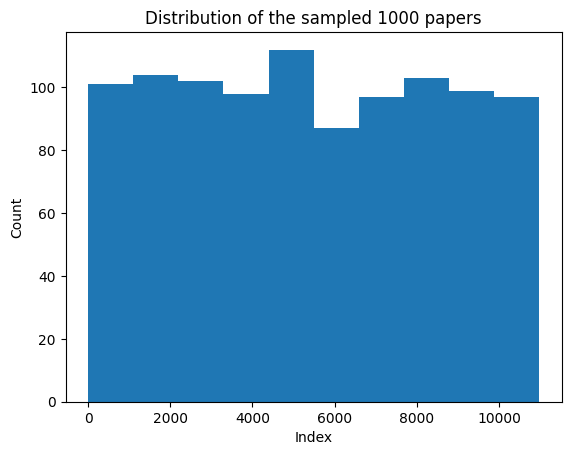

In [372]:
# # draw the distribution of the sampled 1000 papers to see if it's actually randomly sampled
# test_1000_path = fpath.poten_litera_testing_set_1000
# df_1000 = pd.read_csv(test_1000_path, header=0, sep=',')
# df_1000.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]

# index_list = df_1000['INDEX'].tolist()
# index_list.sort()
# # print(index_list)
# print(len(index_list))

# # draw the histogram
# plt.hist(index_list, bins=10)
# plt.xlabel("Index")
# plt.ylabel("Count")
# plt.title("Distribution of the sampled 1000 papers")
# plt.show()

<h3> Next step: automatic filtering </h3>